# Extract reviews of any product from ecommerce website like amazon and perform Emotion Mining
---

For this assignment, we will extract reviews from the website **"headphonezone.in"** for In-Ear Monitors (earphones) called **"KZ - ZST X"**. They are an affordable introduction to the world of IEMs. Different speakers in each shell deal with higher and lower frequencies, so that you get good bass as well as treble.

The product has more than 400 reviews. It displays 7 reviews initially, and on clicking 'Read More' 7 more reviews are loaded through an AJAX call. Also, longer reviews are truncated with a 'Read more' link to display the complete review.

To extract reviews from the product's [webpage](https://www.headphonezone.in/products/kz-zst-x?variant=33086548049983) we will use the *Selenium* library as we want to control the browser to repeatedly click the 'Read more' button until all reviews are displayed and also click 'Read more' for every truncated review.  
Selenium automates browsers. Primarily it is for automating web applications for testing purposes, but is certainly not limited to just that. Boring web-based administration tasks can also be automated.

Once we have the text for all reviews displayed on the webpage, we can use *Beautiful Soup 4* package to parse the page source and locate and extract the required elements.   
Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. It commonly saves programmers hours or days of work.

---

## Web Scraping

In [52]:
# Importing necessary libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.firefox.options import Options
import time

In [62]:
# Launching Firefox browser
driver = webdriver.Firefox()

In [63]:
url = "https://www.headphonezone.in/products/kz-zst-x?variant=33086548049983"
# Launching URL
driver.get(url)

In [64]:
# Creating a 10 second wait
wait = WebDriverWait(driver, 10)
# Creating an object for the web element that contains all reviews
review_window = driver.find_element(By.CSS_SELECTOR, "div.jdgm-rev-widg__reviews")
# Getting the height for this window
initial_height = driver.execute_script("return arguments[0].style.height;", review_window)

In [65]:
# Looping to click 'Read More' to load all reviews in the review window
while True:
    # Creating object for 'Read More' button
    read_more = driver.find_element(By.CSS_SELECTOR, "a.jdgm-paginate__load-more")
    # Using JavaScript Executor to click 'Read More'
    driver.execute_script("arguments[0].click();", read_more)
    # Wait until the height of the review window changes (which means more reviews have loaded after clicking 'Read More')
    wait.until_not(EC.text_to_be_present_in_element_attribute((By.CSS_SELECTOR, "div.jdgm-rev-widg__reviews"), "height", initial_height))
    # Updating the new review window height
    initial_height = driver.execute_script("return arguments[0].style.height;", review_window)
    # Check if the web element containing the 'Read More' button exists on the page, and exit the loop if not, as all reviews have been loaded
    try:
        driver.find_element(By.CSS_SELECTOR, "div.jdgm-paginate")
    except:
        print("All reviews are loaded.")
        break
    # If 'Read More' button still exists, wait until it is visible in the Document Object Model and clickable
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, "a.jdgm-paginate__load-more")))
    wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a.jdgm-paginate__load-more")))

All reviews are loaded.


In [68]:
# Finding all 'Read more' links for individual reviews which were truncated
expands = driver.find_elements(By.CSS_SELECTOR, "div.is-truncated > p > a")

In [69]:
# Expand each truncated review
for expand in expands:
    driver.execute_script("arguments[0].click();", expand)

In [70]:
# Import required library
from bs4 import BeautifulSoup

# Parsing HTML Source code of the webpage into soup object
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [71]:
# Closing the browser as the required information has been extracted
driver.quit()

In [72]:
# Getting a list of all web elements containing reviews
reviews = soup.find_all('div', class_= 'jdgm-rev__body')

In [73]:
# Creating an empty list to store each review as a string
review_list = []

# Adding each review's text into review_list
for review in reviews:
    review_list.append(review.text)

In [74]:
# printing the first 10 reviews
review_list[:10]

["Won't take much of your time so I'll dive right in to the review. Comfort wise they are perfect. At least for my ears but I'm pretty sure it'll fit most of you out there. The earphones are made of plastic shells which look sturdy and can resist your usual wear and tear. The cable is also of the decent quality. But none of the things are the selling point of these headphones. KZ promises audio quality and delivers it! These are not your usual ear candy earphones like boat, sony, redmi, realme, etc and if you prefer that sound signature don't buy it. But if you prefer a clean audio with tight bass airy highs these are the headphones for you. The miss are also present but a bit laid back in the mix. I'd rather call them U shaped rather than V shaped. It lets you hear little details in your music you've never heard before. All in all of you want a balanced headphones these should be my pick and I've used literally every earphone under 2k price braket including rha ma390, soundmagic e10c,

Now, we have successfully web scraped all of the reviews from the product page

## Data Pre-processing

In [76]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [189]:
# Storing all reviews into a dataframe
df = pd.DataFrame(review_list, columns = ['review'])

When we printed the first 10 reviews above, I noticed that all reviews contained 'Read more' at the end. It seems the 'Read more' was within an element in the review body and as we extracted all text from the review body, this was included too. We can remove it

In [190]:
# Removing 'Read more' at the end of each review
df['review'] = df.review.str.replace('Read more$', '', regex = True)

In [191]:
# Storing the dataframe for quick access
df.to_csv("web_scrapped_reviews.csv")

In [192]:
# Replacing emojis with their descriptions
df['review'] = df.review.apply(lambda x : emoji.replace_emoji(x, replace=lambda chars, data_dict: ' ' + chars.encode('ascii', 'namereplace').decode()[3:-1]))

In [193]:
# Getting character length of each review
df['length'] = df.review.apply(lambda x : len(x))

In [194]:
df[df.length < 15]

,review,length
18,Good,4
19,Love them!,10
92,KZ - ZST,8
97,nice,4
124,kz zst x,8
136,Must try,8
139,okok,4
162,Excellent,9
179,Good,4
188,best,4


We can see some reviews only contain 'KZ - ZST' and 'KZ - ZST X'. We can remove them.

In [195]:
# Dropping reviews only containing product name
df.drop(index = df[(df.length < 15) & (df.review.str.contains("ZST", case=False))].index, inplace = True)

In [196]:
# Resetting index
df.reset_index(drop = True, inplace = True)

In [197]:
df[df.length < 20]

,review,length
18,Good,4
19,Love them!,10
96,nice,4
134,Must try,8
137,okok,4
160,Excellent,9
177,Good,4
186,best,4
190,good sound,10
194,I'm very excited,17


## Sentiment Analysis

### VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed to handle social media texts. It is known for its accuracy in detecting sentiment in short texts like tweets.

In [118]:
# importing necessary libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

In [119]:
# Function to return polarity scores
def sentiment_analyzer(text):
    return vader.polarity_scores(text)

In [130]:
# Function to classify review based on polarity score
def sentiment_clf(score):
    if score == 0:
        return 'Neutral'
    elif score > 0:
        return 'Positive'
    else:
        return 'Negative'

In [198]:
# Creating a dataframe of polarity scores for each review
polarity_df = pd.DataFrame(df.review.apply(sentiment_analyzer).values.tolist(), index = df.index)
# Adding polarity scores to original df
df = pd.concat([df, polarity_df], axis = 1)

In [199]:
# Classifying sentiment for the tweet based on polarity scores
df['sentiment'] = df.compound.apply(sentiment_clf)

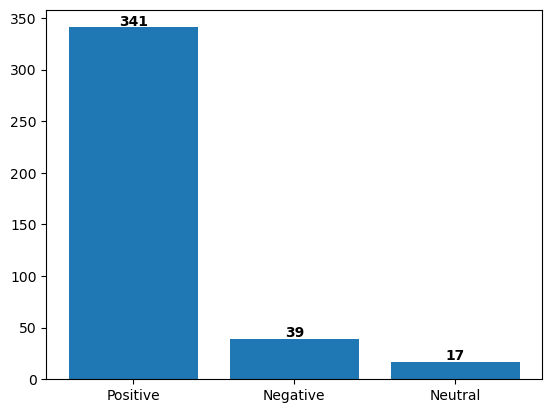

In [200]:
# Barplot of reviews by sentiment
x = df.sentiment.value_counts().index.tolist()
y = df.sentiment.value_counts().values.tolist()
plt.bar(x, y)
for i, v in enumerate(y):
    plt.text(i, v + 2, str(v), color='black', fontweight='bold', ha='center')

In [201]:
# Getting value counts in the form of percentage
df.sentiment.value_counts(normalize=True) * 100

Positive    85.894207
Negative     9.823678
Neutral      4.282116
Name: sentiment, dtype: float64

Nearly 85% reviews are positive. 9% are neutral. Only 4% are negative

In [202]:
no = 0
for i in df[df.sentiment == 'Neutral'].review:
    print(no, ")", i, "\n\n")
    no += 1

0 ) I'm not received any item from Blue dart courier. How can u generate this mail 


1 ) I wan to exchange my product 


2 ) IDk.. WRITING THIS REVIEW TO CHECK IF I GET MY 100 POINTS ON WRITING REVIEW , BUT LOOKING FORWARD TO BUY KZ DQ6 VERY SOON... 


3 ) If you are an audiophile with less than 2k budget close your eyes and go for this. 


4 ) Must try 


5 ) okok 


6 ) Cables are not silver plated as the pictures are sowing.i got copper cables. 


7 ) Very Noice 


8 ) beautiiful sound 


9 ) design is superbly done....sound quality is of another level. 


10 ) Nothing's above it. 


11 ) I didn't really found much difference between kz and boat rockerz 400. they are wireless and 500 lesser in price 


12 ) I have returned my order due to deliver issues and soon i will reorder them on my new address 


13 ) Iam not received the product yet 


14 ) Cheapest and a must have essential for beginners audiophile. 


15 ) By looking the price u it looks cheap and didnt even think the soun

### TextBlob

Another python library for sentiment analysis

In [142]:
from textblob import TextBlob

In [203]:
# Adding polarity and subjectivity columns to df
df['polarity'] = df.review.apply(lambda x : TextBlob(x).polarity)
df['subjectivity'] = df.review.apply(lambda x : TextBlob(x).subjectivity)

<Axes: xlabel='subjectivity', ylabel='polarity'>

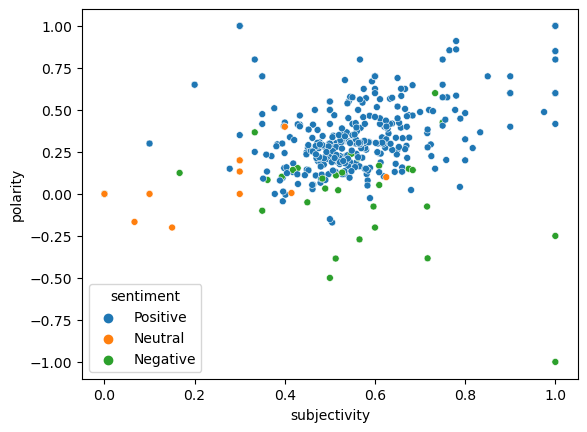

In [204]:
# Scatterplot of reviews with subjectivity on x axis and polarity on y axis, with color representing sentiment classification by VADER
sns.scatterplot(df, x = 'subjectivity', y = 'polarity', hue = 'sentiment', s = 25)

In [219]:
# Reviews with positive sentiment according to TextBlob but not according to VADER
no = 1
for i in df[(df.sentiment == 'Negative') & (df.polarity > 0.25)].review:
    print(no,')  ',i, '\n\n')
    no += 1   

1 )   The looks is good. Delivery was awesome. But the sound hurts my ears. Not happy with the earphone. 


2 )   You wont find a better sounding earphones at this price point period. 


3 )   These iems sound excellent but there eartips aren't at all comfortable 


4 )   Overall product is good as hell but i have some problem to fit the cable to earphone 


5 )   can't explain how amazing these things are..sound quality is "out of this world" 




In [223]:
# Reviews with positive sentiment according to VADER but not according to TextBlob
no = 1
for i in df[(df.sentiment == 'Positive') & (df.polarity < 0)].review:
    print(no,')  ',i, '\n\n')
    no += 1  

1 )   I bought this earphones for playing fps game. And i am not able to play. The directions hearing are awkward. Please make a return. I got the product 2 days back. I am a genuine customer of headphone zone. I have Bought an earphone before also. So please make a return 


2 )   Am not an so called audiophile. Previously I've used budget Sony, Sennheiser, Piston fit earphones. While surfing the headphonezone website got to know about the IEMs. Ordered this as per my budget. It's a completely different ball game. The small details in the instrument seperation.......I haven't noticed with my previous earphones. The base is adequate. Overall a great buy. Thanks Headphonezone. 


3 )   the base is really well defined but lacks the fullerness and warmer tone in the high notes and mid vocals.
    I use AKG flat sound signature headphones and maybe I am used to those but I can always feel a major difference between the twos for the mids and highs.
    But for the price point , cant say muc

We can see that both methods misclassify some, while correctly classifying others, but overall majority of the reviews are correctly classified

In [240]:
blob = TextBlob('''You guys are doing really a great job, in past i was literally crying to have IEMs like these which i got from you because of some stupid silly brands like boat, KZ ZST-X these IEMs are really great in 1600rs bass, vocal and all other things is really out standing GRINNING FACE WITH STAR EYES.
    (I wish to work with you guys) ''')

In [246]:
# Example text
text = '''You guys are doing really a great job, in past i was literally crying to have IEMs like these which i got from you because of some stupid silly brands like boat, KZ ZST-X these IEMs are really great in 1600rs bass, vocal and all other things is really out standing GRINNING FACE WITH STAR EYES.
    (I wish to work with you guys) '''

# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

# Get the emotion probabilities
scores = analyzer.polarity_scores(text)

scores
# Classify the emotion
# emotion = max(scores, key=scores.get)


{'neg': 0.083, 'neu': 0.649, 'pos': 0.268, 'compound': 0.9271}